In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import ast
from geopy.distance import geodesic
import math
import random

In [22]:
satellite = getSatelliteImage();

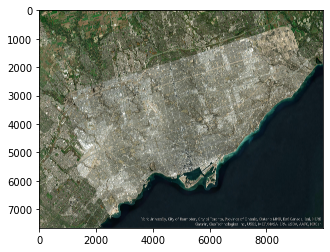

In [23]:
plt.imshow(satellite)

In [24]:
def getSatelliteImage():
    img = cv2.imread("../res/datasets/images/satellite.png", cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    return img;

In [25]:
def getTDCSBSchools():
    return pd.read_csv('../res/datasets/schools/TDCSB_Schools.csv', sep = ',')

tdcsbSchools = getTDCSBSchools()

In [26]:
tdcsbSchools

,_id,OBJECTID,TCDSB_CODE,SCH_NAME,ADDRESS_FULL,MUNICIPALITY,POSTAL_CODE,TCDSB_LEVEL,STATUS,geometry
0,1,1,299,Annunciation,65 Avonwick Gt,North York,M3A 2M8,E,Open,"{'type': 'Point', 'coordinates': (-79.32126781..."
1,2,2,290,All Saints,1435 Royal York Rd,Etobicoke,M9P 3A7,E,Open,"{'type': 'Point', 'coordinates': (-79.52716292..."
2,3,3,222,St. Martin Program,55 Salisbury Ave,former Toronto,M4X 1C5,AL,Open,"{'type': 'Point', 'coordinates': (-79.36442584..."
3,4,4,545,Bishop Marrocco-Thomas Merton,1515 Bloor St W,former Toronto,M6P 1A3,S,Open,"{'type': 'Point', 'coordinates': (-79.45180771..."
4,5,5,549,Bishop Allen Academy,721 Royal York Rd,Etobicoke,M8Y 2T3,S,Open,"{'type': 'Point', 'coordinates': (-79.50446467..."
...,...,...,...,...,...,...,...,...,...,...
205,206,206,239,Our Lady of Perpetual Help,1 1/2 Garfield Ave,former Toronto,M4T 1E6,E,Open,"{'type': 'Point', 'coordinates': (-79.38330488..."
206,207,207,291,St Josaphat,110 Tenth St,Etobicoke,M8V 3G1,E,Open,"{'type': 'Point', 'coordinates': (-79.50905953..."
207,208,208,412,North East SAL Program,100 Fundy Bay Blvd,Scarborough,M1W 3G1,AL,Open,"{'type': 'Point', 'coordinates': (-79.31660336..."
208,209,209,848,East Facilities,97 Railside Rd,North York,M3A 1B2,ADM,Open,"{'type': 'Point', 'coordinates': (-79.32406504..."


In [27]:
def getPopDensityImage():
    img = cv2.imread("../res/datasets/images/pop_density.png", cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    return img;

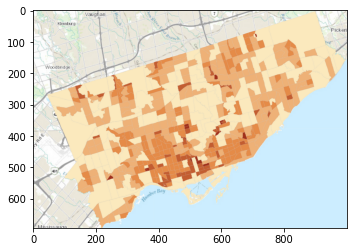

In [28]:
popDensity = getPopDensityImage()
plt.imshow(popDensity)

In [29]:
def getPedestrian():
    return pd.read_csv('../res/datasets/pedestrian/Pedestrian_Network_Data.csv', sep = ',')

In [30]:
pedestrian = getPedestrian()
pedestrian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87105 entries, 0 to 87104
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _id                   87105 non-null  int64  
 1   OBJECTID              87105 non-null  int64  
 2   ROAD_TYPE             86315 non-null  object 
 3   SIDEWALK_CODE         87105 non-null  int64  
 4   SIDEWALK_DESCRIPTION  84409 non-null  object 
 5   CROSSWALK             87105 non-null  int64  
 6   CROSSWALK_TYPE        9308 non-null   object 
 7   PX                    7626 non-null   float64
 8   PX_TYPE               7626 non-null   object 
 9   LENGTH                87105 non-null  float64
 10  Shape__Length         87105 non-null  float64
 11  geometry              87105 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 8.0+ MB


In [31]:
cols = ['OBJECTID', '_id', 'CROSSWALK_TYPE', 'SIDEWALK_CODE', 'CROSSWALK', 'PX_TYPE', 'PX']
pedestrian = pedestrian.drop(cols, axis=1)

In [32]:
pedestrian

,ROAD_TYPE,SIDEWALK_DESCRIPTION,LENGTH,Shape__Length,geometry
0,Local,Sidewalk on both sides,93.867680,129.824322,"{'type': 'LineString', 'coordinates': ((-79.56..."
1,Collector,Sidewalk on both sides,32.546284,44.903807,"{'type': 'LineString', 'coordinates': ((-79.56..."
2,NaN,Sidewalk on north side only,117.669206,162.522572,"{'type': 'LineString', 'coordinates': ((-79.37..."
3,NaN,Sidewalk on both sides,223.269710,309.035596,"{'type': 'LineString', 'coordinates': ((-79.51..."
4,Local,Sidewalk on both sides,201.335648,278.478601,"{'type': 'LineString', 'coordinates': ((-79.30..."
...,...,...,...,...,...
87100,Walkway,City walkway,32.249129,44.584927,"{'type': 'LineString', 'coordinates': ((-79.57..."
87101,Walkway,City walkway,26.786411,37.023492,"{'type': 'LineString', 'coordinates': ((-79.57..."
87102,Walkway,City walkway,32.846849,45.381530,"{'type': 'LineString', 'coordinates': ((-79.56..."
87103,Walkway,City walkway,30.031629,41.511419,"{'type': 'LineString', 'coordinates': ((-79.57..."


In [33]:
pedestrian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87105 entries, 0 to 87104
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ROAD_TYPE             86315 non-null  object 
 1   SIDEWALK_DESCRIPTION  84409 non-null  object 
 2   LENGTH                87105 non-null  float64
 3   Shape__Length         87105 non-null  float64
 4   geometry              87105 non-null  object 
dtypes: float64(2), object(3)
memory usage: 3.3+ MB


In [34]:
coordinates = tdcsbSchools.drop(['_id', 'OBJECTID', 'TCDSB_CODE', 'SCH_NAME','ADDRESS_FULL', 'MUNICIPALITY', 'POSTAL_CODE', 'TCDSB_LEVEL', 'STATUS'], 
                  axis = 1)

In [35]:
coordinates = coordinates['geometry'].astype('str')
coordinates = coordinates.apply(lambda x: ast.literal_eval(x))
coordinates = coordinates.apply(pd.Series)

In [36]:
#these are not data frames but instead series 
#be careful when working with them

Latitude = coordinates['coordinates'].apply(lambda x: x[1])
Longitude = coordinates['coordinates'].apply(lambda x: x[0])

Longitude

0     -79.321268
1     -79.527163
2     -79.364426
3     -79.451808
4     -79.504465
         ...    
205   -79.383305
206   -79.509060
207   -79.316603
208   -79.324065
209   -79.509603
Name: coordinates, Length: 210, dtype: float64

In [37]:
def getDistance(origin, stationCor):
    return (geodesic(origin, stationCor).meters/1000)

In [38]:
def score(latStation, longStation, stdDev, latOrigin, longOrigin):
    
    stationCor = (latStation, longStation)
    
    totalScore = 0
    count = 0
    
    for Lat, Long in zip(latOrigin, longOrigin):
            
            origin = (Lat, Long)
            
            r = getDistance(origin, stationCor)
            
            #this can be updated to have a different standard deviation I just chose to have it as
            #0.4 as 0.4km should be where majority of distances fall in
            score = abs((1/(stdDev * math.sqrt(2 * math.pi))) * math.exp(-0.5 * ((r/stdDev)**2)))
            
            totalScore += score
            
    #adjustFactor = 210 * 0.9974
    
    #totalScore = (totalScorePre/adjustFactor)*100
    
    return totalScore

In [39]:
upperLatBound = 43.806535
bottomLatBound = 43.567208
leftLongBound = -79.597003
rightLongBound = -79.322181

n = 50

scores = pd.DataFrame(columns = ['lat', 'long', 'score'])

for lat in np.arange(bottomLatBound, upperLatBound, (upperLatBound-bottomLatBound)/n):
    
    for long in np.arange(leftLongBound, rightLongBound, (rightLongBound-leftLongBound)/n):
        
        scores = scores.append({'lat' : lat, 'long' : long, 'score' : score(lat, long, 0.6, Latitude, Longitude)}, ignore_index = True)
        
        # print(score(lat, long, 0.4, Latitude, Longitude))
        # plot like this: lat - bottomLatBound,  long - leftLongBound



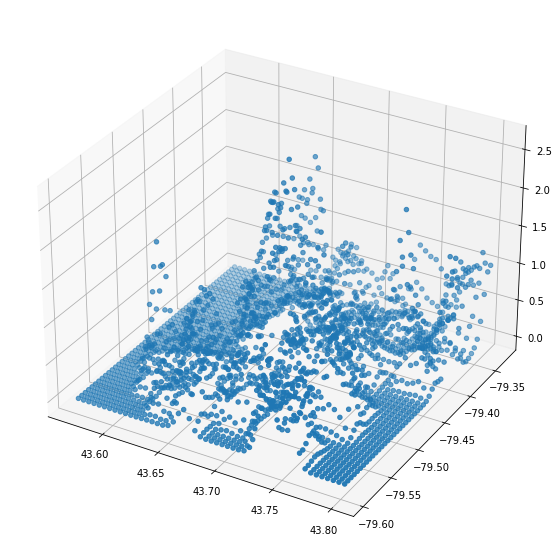

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_figheight(10)
fig.set_figwidth(10)

ax.scatter(scores["lat"], scores["long"], scores["score"])